<h3>Usage:</h3>
<p>This dataset is suitable for tasks such as predictive modeling, clustering, and exploratory data analysis. It provides valuable insights for understanding the relationships between personal and lifestyle factors and mental health outcomes, specifically focusing on depression detection and prevention.</p>

In this project, we will use information about patient to predict if they have some **chronic medical conditions** or if they are **depressive**.

Data sourced from: <a href="https://www.kaggle.com/datasets/anthonytherrien/depression-dataset">Kaggle Depression Dataset</a>.

# Necessary setup

Note that this project has been realised under `python 3.11` as **capstone project** for the **2024 ML Zoomcamp**.

## Install

Let's install `kaggle` to be able to download datasets from Kaggle.

In [1]:
# install kaggle library
!pip install kaggle
!pip install xgboost

To use the command line interface, `'Kaggle CLI tool'`, we had to set up our **API keys**. 

For this, we went to the `'Account'` tab of our user profile on Kaggle, and selected `'Create New Token'`. This triggered the download of `kaggle.json`, a file containing our *API credentials*. We then made sure that the token was saved at *~/.kaggle/kaggle.json*, as we are working on `Ubuntu` (WSL distribution). It is the same address to verify for Linux, OSX, and other UNIX-based operating systems. For Windows, check *C:\Users\<Windows-username>\.kaggle\kaggle.json* instead. If the token is not there, an error will be raised. Hence, once downloaded the token, it should be moved to this folder.

## Import

In [2]:
# Necessary import
import pickle # to manipulate models
import zipfile # to manipulate .zip file
import xgboost as xgb # for gradient boosting classifier
import numpy as np # for matrices and numerical manipulations
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plots
import seaborn as sns # for visualizing data

from sklearn.metrics import mutual_info_score # for feature importance
from sklearn.feature_extraction import DictVectorizer # for One-Hot Encoding
from sklearn.model_selection import train_test_split, KFold # for cross-validation techniques
from sklearn.linear_model import LogisticRegression # for logistic regression model
from sklearn.tree import DecisionTreeClassifier # for decision trees
from sklearn.ensemble import RandomForestClassifier # for random forest classifier

In [3]:
# Import only to get versions
import sys # for the system
import matplotlib, sklearn # for visualization and modelisation library

In [4]:
# System versions
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---" * 47)

# Libraries versions
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("sklearn version:", sklearn.__version__)
print("XGBoost version:", xgb.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)

Platform: linux
Python version: 3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]
---------------------------------------------------------------------------------------------------------------------------------------------
matplotlib version: 3.9.2
seaborn version: 0.13.2
sklearn version: 1.5.1
XGBoost version: 2.1.2
pandas version: 2.2.2
numpy version: 1.26.4


# Data Sourcing

Let's download the [dataset](https://www.kaggle.com/datasets/anthonytherrien/depression-dataset) using the command line interface (`CLI`):

In [5]:
# download the data
!kaggle datasets download anthonytherrien/depression-dataset

Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/depression-dataset
License(s): CC-BY-SA-4.0
100%|██████████████████████████████████████| 8.69M/8.69M [02:16<00:00, 42.0kB/s]
100%|██████████████████████████████████████| 8.69M/8.69M [02:16<00:00, 66.9kB/s]


In [6]:
# list files in current directory
!ls

LICENSE    capstone_project_01.ipynb  depression-dataset.zip  images
README.md  data			      draft


A .zip file (`depression-dataset.zip`) containing the dataset has been downloaded. We will extract the data and store it into the `data` folder.

In [7]:
# Unzip the `depression-dataset.zip` file
with zipfile.ZipFile("depression-dataset.zip", "r") as depression_data:
    depression_data.extractall("data") # extract all files to the data directory

In [8]:
# list files in the folder `data`
!ls data

depression_data.csv


We can see that there is now a new .csv file: `depression_data.csv`, in the `data` directory.

Let's visualize its first lines:

In [9]:
# dataset first rows
!head data/depression_data.csv

Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes
Kathy Hill,20,Single,High School,0,Former,Active,Employed,44448.91,Low,Unhealthy,Fair,No,Yes,No,No
Crystal Delgado,60,Widowed,Associat

We can now read the dataset as a dataframe:

In [45]:
# Read the dataframe
df = pd.read_csv("data/depression_data.csv")

# Three last rows
df.tail(3)

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
413765,Matthew Jenkins,57,Married,Bachelor's Degree,0,Non-smoker,Sedentary,Employed,77353.26,Moderate,Moderate,Fair,No,No,Yes,Yes
413766,Gary Faulkner,71,Married,Associate Degree,2,Non-smoker,Sedentary,Unemployed,24557.08,Moderate,Moderate,Poor,No,Yes,No,No
413767,Joseph Johnson,62,Widowed,Master's Degree,0,Former,Moderate,Employed,107125.74,Moderate,Healthy,Good,No,Yes,No,No


# Exporatory Data Analysis & Data Preparation

Let's get more information about the dataset:

In [46]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

In [47]:
# Check missing values
df.isna().sum()

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

In [48]:
# Check of duplicated rows
df.duplicated().sum()

0

The dataset does not have any missing values, and duplicated rows.

We can rename the variable names to uniformize them.

In [59]:
# Normalisation of column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
# Dataset column names
df.columns

Index(['age', 'marital_status', 'education_level', 'number_of_children',
       'smoking_status', 'physical_activity_level', 'employment_status',
       'income', 'alcohol_consumption', 'dietary_habits', 'sleep_patterns',
       'history_of_mental_illness', 'history_of_substance_abuse',
       'family_history_of_depression', 'chronic_medical_conditions'],
      dtype='object')

The column `name` has private information that will not be used for training our models and that we would prefere to disclose.

In [50]:
# drop patient names
df.drop(columns = "name", inplace = True)

## Target Variable Analysis

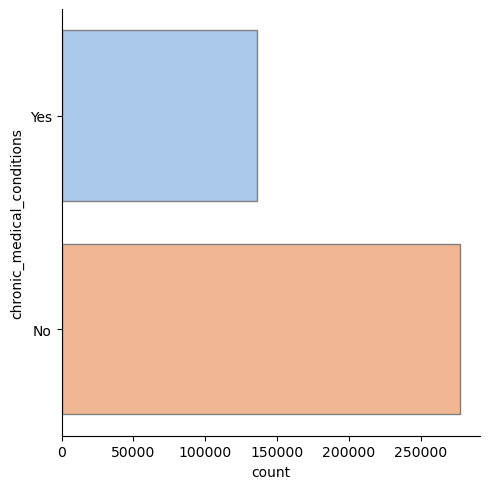

In [51]:
# Target variable distribution
sns.catplot(df, y = "chronic_medical_conditions", kind = "count",
            hue = "chronic_medical_conditions",
            palette = "pastel",
            edgecolor = ".5");

The data distribution for the target variable is highly unbalanced. There are many options to fix this issue:

- Balancing the data: either with downsampling, oversampling, or a method mixing both techniques.
- Using a metric that is suitable for unbalanced data such as the **AUC score**, or the **F1 score**.

In this project, as the dataset is quite huge, we will perform a **down-sampling technique** to under-sample the majority class (`No`) so it reaches the minority one (`Yes`). We will perform this down-sampling with the `sample()` pandas method and `random_state` of `37` for reproducibility.

In [52]:
# Get the minority class size
down_size = len(df[df.chronic_medical_conditions == "Yes"])
down_size # output this size

136207

In [53]:
# Get a down-sampled subset of the majority class
df_maj_class = df[df.chronic_medical_conditions == "No"].sample(n = down_size, random_state = 37)

# Build the balanced dataset
bal_df = pd.concat([df_maj_class, # majority class
                    df[df.chronic_medical_conditions == "Yes"] # minority class
                   ])
# Let's shuffle the data-set
bal_df = bal_df.sample(frac = 1, random_state = 1).reset_index(drop = True)

# Data shape
print(f"Data Shape: {bal_df.shape[0]} rows and {bal_df.shape[1]} columns.", "---"*37)
# First elements of the resampled
bal_df.head(3)

Data Shape: 272414 rows and 15 columns. ---------------------------------------------------------------------------------------------------------------


,age,marital_status,education_level,number_of_children,smoking_status,physical_activity_level,employment_status,income,alcohol_consumption,dietary_habits,sleep_patterns,history_of_mental_illness,history_of_substance_abuse,family_history_of_depression,chronic_medical_conditions
0,22,Single,Associate Degree,0,Current,Moderate,Employed,59302.22,High,Unhealthy,Poor,Yes,No,No,Yes
1,64,Married,Master's Degree,1,Non-smoker,Sedentary,Employed,82646.99,Moderate,Unhealthy,Poor,No,Yes,No,No
2,38,Single,Bachelor's Degree,0,Current,Sedentary,Employed,62609.04,Low,Unhealthy,Fair,No,Yes,No,No


We have a new dataset. Let's make sure it is well balanced by visualizing the target proportion with a pie chart.

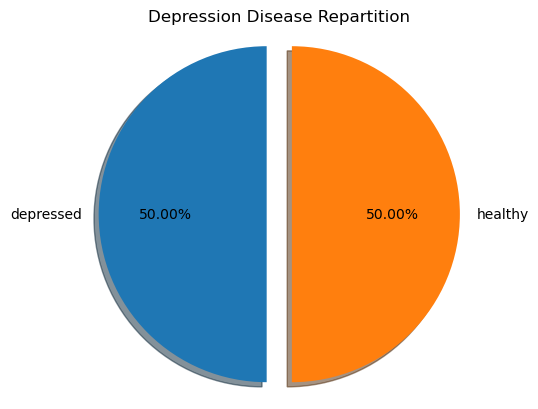

In [54]:
# Labels
labs_names = ['depressed','healthy']
# Target value counts
data_counts = list(bal_df["chronic_medical_conditions"].value_counts())
# Space between pies
pie_space = (0.15, 0)
# Title
plt.title('Depression Disease Repartition')
# Target variable distribution Pie chart
plt.pie(data_counts, explode = pie_space, labels = labs_names , autopct = '%1.2f%%',
        startangle = 90, shadow = True)
# Put title and plot on same axis
plt.axis('equal');

The dataset is now well balanced. If we drop any data during data cleaning. We will proceed to another check to verify wether we can use `accuracy score` as metric to evaluate our models.

## Summary Statistics

In [60]:
# list of categorical feature variables
numerical = bal_df.select_dtypes("number").columns.to_list()
numerical

['age', 'number_of_children', 'income']

In [61]:
# Data description
bal_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,272414.0,48.88,18.17,18.00,33.00,49.00,65.00,80.00
number_of_children,272414.0,1.30,1.24,0.00,0.00,1.00,2.00,4.00
income,272414.0,50205.16,40570.14,0.41,20613.74,37028.01,75477.26,209995.22


There are some outliers in the `income` variable. According to the fact that patient ages vary between `18` to `80` years old, and with real world possibilities, those values, may them be very small (`0.41`), or very large (`209995.22`) are certiainly correct values.

However, let's visualize the distribution of numerical variables better to get more information.

## Numerical features data distribution

In [ ]:
# Histograms of numerical variables
df.hist(figsize = (10, 10));

## Categorical variables values

In [56]:
# list of categorical feature variables
categorical = df.drop(columns = "chronic_medical_conditions").select_dtypes("object").columns.to_list()
categorical

['marital_status',
 'education_level',
 'smoking_status',
 'physical_activity_level',
 'employment_status',
 'alcohol_consumption',
 'dietary_habits',
 'sleep_patterns',
 'history_of_mental_illness',
 'history_of_substance_abuse',
 'family_history_of_depression']

In [45]:
# For each categorical variable
for cat in categorical:
    # Print the variable and its values
    print(f"- {cat} --> {df[cat].unique()} \n")

- Name --> ['Christine Barker' 'Jacqueline Lewis' 'Shannon Church' ...
 'Madeline Butler' 'Travis Brewer' 'Gary Faulkner'] 

- Marital Status --> ['Married' 'Widowed' 'Divorced' 'Single'] 

- Education Level --> ["Bachelor's Degree" 'High School' "Master's Degree" 'Associate Degree'
 'PhD'] 

- Smoking Status --> ['Non-smoker' 'Former' 'Current'] 

- Physical Activity Level --> ['Active' 'Sedentary' 'Moderate'] 

- Employment Status --> ['Unemployed' 'Employed'] 

- Alcohol Consumption --> ['Moderate' 'High' 'Low'] 

- Dietary Habits --> ['Moderate' 'Unhealthy' 'Healthy'] 

- Sleep Patterns --> ['Fair' 'Good' 'Poor'] 

- History of Mental Illness --> ['Yes' 'No'] 

- History of Substance Abuse --> ['No' 'Yes'] 

- Family History of Depression --> ['Yes' 'No'] 



---